In [1]:
import torch
import numpy as np

In [2]:
x = torch.randn(3,requires_grad =True)
x
y = x+2
print(y,y.grad_fn)
z = y*y*3
print(z)
#z.backward()
z = z.mean()
print(z)
#now it workd
z.backward()
print(x.grad)  # dz/dx --> local gradient



tensor([1.6279, 2.2870, 0.9885], grad_fn=<AddBackward0>) <AddBackward0 object at 0x7fd5340b81d0>
tensor([ 7.9504, 15.6909,  2.9312], grad_fn=<MulBackward0>)
tensor(8.8575, grad_fn=<MeanBackward0>)
tensor([3.2558, 4.5740, 1.9769])


In [13]:
x = torch.randn(3, requires_grad =True)
y = x*2
for _ in range(10):
    y = y*2
print(y.shape)
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float32)
y.backward(v)
print(x.grad)

torch.Size([3])
tensor([2.0480e+02, 2.0480e+03, 2.0480e-01])


In [16]:
# -------------
# Stop a tensor from tracking history:
# For example during our training loop when we want to update our weights
# then this update operation should not be part of the gradient computation
# - x.requires_grad_(False)
# - x.detach()
# - wrap in 'with torch.no_grad():'

# .requires_grad_(...) changes an existing flag in-place.

a = torch.randn(2, 2)
print(a.requires_grad)
b = ((a * 3) / (a - 1))
print(b.grad_fn)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

# .detach(): get a new Tensor with the same content but no gradient computation:
a = torch.randn(2, 2, requires_grad=True)
print(a.requires_grad)
b = a.detach()
print(b.requires_grad)

# wrap in 'with torch.no_grad():'
a = torch.randn(2, 2, requires_grad=True)
print(a.requires_grad)
with torch.no_grad():
    print((x ** 2).requires_grad)

False
None
True
True
False
True
False


### backpropagation

In [19]:
# -------------
# backward() accumulates the gradient for this tensor into .grad attribute.
# !!! We need to be careful during optimization !!!
# Use .zero_() to empty the gradients before a new optimization step!
weights = torch.ones(4, requires_grad=True)
print(weights)
for epoch in range(3):
    # just a dummy example
    model_output = (weights*3).sum()
    model_output.backward()
    
    print(weights.grad)

    # optimize model, i.e. adjust weights...
    with torch.no_grad():
        weights -= 0.1 * weights.grad

    # this is important! It affects the final weights & output
    weights.grad.zero_()

print(weights)
print(model_output)


tensor([1., 1., 1., 1.], requires_grad=True)
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([3., 3., 3., 3.])
tensor([0.1000, 0.1000, 0.1000, 0.1000], requires_grad=True)
tensor(4.8000, grad_fn=<SumBackward0>)


# forwardpass gradient descent

In [28]:
# Linear regression
# f = w * x 

# here : f = 2 * x
X = np.array([1, 2, 3, 4], dtype=np.float32)
Y = np.array([2, 4, 6, 8], dtype=np.float32)

w = 0.0

# model output
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

# J = MSE = 1/N * (w*x - y)**2
# dJ/dw = 1/N * 2x(w*x - y)
def gradient(x, y, y_pred):
    return np.dot(2*x, y_pred - y).mean()

print(f'Prediction before training: f(5) = {forward(5):.3f}')

# Training
learning_rate = 0.01
n_iters = 20

for epoch in range(n_iters):
    # predict = forward pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)
    
    # calculate gradients
    dw = gradient(X, Y, y_pred)

    # update weights
    w -= learning_rate * dw

    if epoch % 2 == 0:
        print(f'epoch {epoch+1}: w = {w:.3f}, loss = {l:.8f}')
        

print(f'Prediction after training: f(5) = {forward(5):.3f}')


Prediction before training: f(5) = 0.000
epoch 1: w = 1.200, loss = 30.00000000
epoch 3: w = 1.872, loss = 0.76800019
epoch 5: w = 1.980, loss = 0.01966083
epoch 7: w = 1.997, loss = 0.00050331
epoch 9: w = 1.999, loss = 0.00001288
epoch 11: w = 2.000, loss = 0.00000033
epoch 13: w = 2.000, loss = 0.00000001
epoch 15: w = 2.000, loss = 0.00000000
epoch 17: w = 2.000, loss = 0.00000000
epoch 19: w = 2.000, loss = 0.00000000
Prediction after training: f(5) = 10.000


## gradients using backward pass

In [65]:
# need 2 torch
#X = torch.tensor([1,2,5,6,8], dtype = torch.float32)
#Y = torch.tensor([2,4,6,7,9], dtype = torch.float32)
X = torch.tensor([1,2,3,4,5], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8,10], dtype=torch.float32)

w = torch.tensor(0.0, dtype = torch.float32, requires_grad = True)
print(w)
def forward(x):
    return w*x

def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

print(f'Prediction before training: f(5) = {forward(6).item():.3f}')

# initial training
learning_rate = 0.01
steps = 100

for epoch in range(steps):
    # pred
    y_pred = forward(X)
    
    #loss actual - predicted
    l = loss(Y,y_pred)
    
    # gradient now backwards
    l.backward()
    
    # update weights
    with torch.no_grad():
        w -= learning_rate * w.grad
    
    #zero the gradients after updating
    w.grad.zero_()
    #print(dir(w.grad))
    if epoch % 100 == 0:
        #print(y_pred)
        print(f'epoch {epoch+1}: w = {w.item():.3f}, loss= {l.item():.4f}')

print(f'Prediction after training: f(5) = {forward(5).item():.3f}')        

tensor(0., requires_grad=True)
Prediction before training: f(5) = 0.000
epoch 1: w = 0.440, loss= 44.0000
Prediction after training: f(5) = 10.000


In [40]:

# Linear regression
# f = w * x 

# here : f = 2 * x
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# model output
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_pred):
    return ((y_pred - y)**2).mean()

print(f'Prediction before training: f(5) = {forward(5).item():.3f}')

# Training
learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    # predict = forward pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    #w.data = w.data - learning_rate * w.grad
    with torch.no_grad():
        w -= learning_rate * w.grad
    
    # zero the gradients after updating
    w.grad.zero_()

    if epoch % 10 == 0:
        print(f'epoch {epoch+1}: w = {w.item():.3f}, loss = {l.item():.8f}')

print(f'Prediction after training: f(5) = {forward(5).item():.3f}')
print(y_pred)

Prediction before training: f(5) = 0.000
epoch 1: w = 0.300, loss = 30.00000000
epoch 11: w = 1.665, loss = 1.16278565
epoch 21: w = 1.934, loss = 0.04506890
epoch 31: w = 1.987, loss = 0.00174685
epoch 41: w = 1.997, loss = 0.00006770
epoch 51: w = 1.999, loss = 0.00000262
epoch 61: w = 2.000, loss = 0.00000010
epoch 71: w = 2.000, loss = 0.00000000
epoch 81: w = 2.000, loss = 0.00000000
epoch 91: w = 2.000, loss = 0.00000000
Prediction after training: f(5) = 10.000
tensor([2.0000, 4.0000, 6.0000, 8.0000], grad_fn=<MulBackward0>)


## Optimizer

In [90]:
# 1) Design model (input, output, forward pass with different layers)
# 2) Construct loss and optimizer
# 3) Training loop
#       - Forward = compute prediction and loss
#       - Backward = compute gradients
#       - Update weights

import torch
import torch.nn as nn

# Linear regression
# f = w * x 

# here : f = 2 * x

# 0) Training samples
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

# 1) Design Model: Weights to optimize and forward function
w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

def forward(x):
    return w * x

print(f'Prediction before training: f(5) = {forward(4).item():.3f}')

# 2) Define loss and optimizer
learning_rate = 0.001
n_iters = 3000

# callable function
loss = nn.MSELoss()

optimizer = torch.optim.Adam([w], lr=learning_rate)

# 3) Training loop
for epoch in range(n_iters):
    # predict = forward pass
    y_predicted = forward(X)
    
    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    if epoch % 10 == 0:
        print('epoch ', epoch+1, ': w = ', w, ' loss = ', l)

print(f'Prediction after training: f(5) = {forward(4).item():.3f}')
print(y_predicted)

Prediction before training: f(5) = 0.000
epoch  1 : w =  tensor(0.0010, requires_grad=True)  loss =  tensor(30., grad_fn=<MeanBackward0>)
epoch  11 : w =  tensor(0.0110, requires_grad=True)  loss =  tensor(29.7008, grad_fn=<MeanBackward0>)
epoch  21 : w =  tensor(0.0210, requires_grad=True)  loss =  tensor(29.4034, grad_fn=<MeanBackward0>)
epoch  31 : w =  tensor(0.0310, requires_grad=True)  loss =  tensor(29.1079, grad_fn=<MeanBackward0>)
epoch  41 : w =  tensor(0.0409, requires_grad=True)  loss =  tensor(28.8144, grad_fn=<MeanBackward0>)
epoch  51 : w =  tensor(0.0508, requires_grad=True)  loss =  tensor(28.5232, grad_fn=<MeanBackward0>)
epoch  61 : w =  tensor(0.0607, requires_grad=True)  loss =  tensor(28.2341, grad_fn=<MeanBackward0>)
epoch  71 : w =  tensor(0.0706, requires_grad=True)  loss =  tensor(27.9472, grad_fn=<MeanBackward0>)
epoch  81 : w =  tensor(0.0805, requires_grad=True)  loss =  tensor(27.6624, grad_fn=<MeanBackward0>)
epoch  91 : w =  tensor(0.0903, requires_grad=

epoch  981 : w =  tensor(0.8663, requires_grad=True)  loss =  tensor(9.6518, grad_fn=<MeanBackward0>)
epoch  991 : w =  tensor(0.8739, requires_grad=True)  loss =  tensor(9.5228, grad_fn=<MeanBackward0>)
epoch  1001 : w =  tensor(0.8815, requires_grad=True)  loss =  tensor(9.3950, grad_fn=<MeanBackward0>)
epoch  1011 : w =  tensor(0.8891, requires_grad=True)  loss =  tensor(9.2686, grad_fn=<MeanBackward0>)
epoch  1021 : w =  tensor(0.8966, requires_grad=True)  loss =  tensor(9.1434, grad_fn=<MeanBackward0>)
epoch  1031 : w =  tensor(0.9041, requires_grad=True)  loss =  tensor(9.0194, grad_fn=<MeanBackward0>)
epoch  1041 : w =  tensor(0.9116, requires_grad=True)  loss =  tensor(8.8968, grad_fn=<MeanBackward0>)
epoch  1051 : w =  tensor(0.9191, requires_grad=True)  loss =  tensor(8.7753, grad_fn=<MeanBackward0>)
epoch  1061 : w =  tensor(0.9265, requires_grad=True)  loss =  tensor(8.6551, grad_fn=<MeanBackward0>)
epoch  1071 : w =  tensor(0.9339, requires_grad=True)  loss =  tensor(8.536

epoch  1871 : w =  tensor(1.4425, requires_grad=True)  loss =  tensor(2.3351, grad_fn=<MeanBackward0>)
epoch  1881 : w =  tensor(1.4478, requires_grad=True)  loss =  tensor(2.2911, grad_fn=<MeanBackward0>)
epoch  1891 : w =  tensor(1.4531, requires_grad=True)  loss =  tensor(2.2478, grad_fn=<MeanBackward0>)
epoch  1901 : w =  tensor(1.4583, requires_grad=True)  loss =  tensor(2.2050, grad_fn=<MeanBackward0>)
epoch  1911 : w =  tensor(1.4635, requires_grad=True)  loss =  tensor(2.1630, grad_fn=<MeanBackward0>)
epoch  1921 : w =  tensor(1.4687, requires_grad=True)  loss =  tensor(2.1215, grad_fn=<MeanBackward0>)
epoch  1931 : w =  tensor(1.4738, requires_grad=True)  loss =  tensor(2.0806, grad_fn=<MeanBackward0>)
epoch  1941 : w =  tensor(1.4789, requires_grad=True)  loss =  tensor(2.0404, grad_fn=<MeanBackward0>)
epoch  1951 : w =  tensor(1.4840, requires_grad=True)  loss =  tensor(2.0008, grad_fn=<MeanBackward0>)
epoch  1961 : w =  tensor(1.4891, requires_grad=True)  loss =  tensor(1.9

epoch  2821 : w =  tensor(1.8202, requires_grad=True)  loss =  tensor(0.2432, grad_fn=<MeanBackward0>)
epoch  2831 : w =  tensor(1.8228, requires_grad=True)  loss =  tensor(0.2361, grad_fn=<MeanBackward0>)
epoch  2841 : w =  tensor(1.8255, requires_grad=True)  loss =  tensor(0.2291, grad_fn=<MeanBackward0>)
epoch  2851 : w =  tensor(1.8281, requires_grad=True)  loss =  tensor(0.2223, grad_fn=<MeanBackward0>)
epoch  2861 : w =  tensor(1.8307, requires_grad=True)  loss =  tensor(0.2157, grad_fn=<MeanBackward0>)
epoch  2871 : w =  tensor(1.8332, requires_grad=True)  loss =  tensor(0.2093, grad_fn=<MeanBackward0>)
epoch  2881 : w =  tensor(1.8357, requires_grad=True)  loss =  tensor(0.2030, grad_fn=<MeanBackward0>)
epoch  2891 : w =  tensor(1.8382, requires_grad=True)  loss =  tensor(0.1968, grad_fn=<MeanBackward0>)
epoch  2901 : w =  tensor(1.8407, requires_grad=True)  loss =  tensor(0.1909, grad_fn=<MeanBackward0>)
epoch  2911 : w =  tensor(1.8432, requires_grad=True)  loss =  tensor(0.1

### model loss and optimizer steps

In [92]:
# 1) Design model (input, output, forward pass with different layers)
# 2) Construct loss and optimizer
# 3) Training loop
#       - Forward = compute prediction and loss
#       - Backward = compute gradients
#       - Update weights

import torch
import torch.nn as nn

# Linear regression
# f = w * x 

# here : f = 2 * x

# 0) Training samples, watch the shape!
X = torch.tensor([[1], [2], [3], [4]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

n_samples, n_features = X.shape
print(f'#samples: {n_samples}, #features: {n_features}')
# 0) create a test sample
X_test = torch.tensor([5], dtype=torch.float32)

# 1) Design Model, the model has to implement the forward pass!
# Here we can use a built-in model from PyTorch
input_size = n_features
output_size = n_features

# we can call this model with samples X
model = nn.Linear(input_size, output_size)

'''
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        # define diferent layers
        self.lin = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x)

model = LinearRegression(input_size, output_size)
'''

print(f'Prediction before training: f(5) = {model(X_test).item():.3f}')

# 2) Define loss and optimizer
learning_rate = 0.01
n_iters = 100

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(n_iters):
    # predict = forward pass with our model
    y_predicted = model(X)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    if epoch % 10 == 0:
        [w, b] = model.parameters() # unpack parameters
        print('epoch ', epoch+1, ': w = ', w[0][0].item(), ' loss = ', l)

print(f'Prediction after training: f(5) = {model(X_test).item():.3f}')
print(y_predicted)

#samples: 4, #features: 1
Prediction before training: f(5) = -4.734
epoch  1 : w =  -0.3842853903770447  loss =  tensor(68.4450, grad_fn=<MeanBackward0>)
epoch  11 : w =  1.5137978792190552  loss =  tensor(1.7922, grad_fn=<MeanBackward0>)
epoch  21 : w =  1.8221360445022583  loss =  tensor(0.0665, grad_fn=<MeanBackward0>)
epoch  31 : w =  1.8746757507324219  loss =  tensor(0.0207, grad_fn=<MeanBackward0>)
epoch  41 : w =  1.8859834671020508  loss =  tensor(0.0184, grad_fn=<MeanBackward0>)
epoch  51 : w =  1.8905748128890991  loss =  tensor(0.0173, grad_fn=<MeanBackward0>)
epoch  61 : w =  1.894003987312317  loss =  tensor(0.0163, grad_fn=<MeanBackward0>)
epoch  71 : w =  1.8971667289733887  loss =  tensor(0.0154, grad_fn=<MeanBackward0>)
epoch  81 : w =  1.9002091884613037  loss =  tensor(0.0145, grad_fn=<MeanBackward0>)
epoch  91 : w =  1.9031578302383423  loss =  tensor(0.0136, grad_fn=<MeanBackward0>)
Prediction after training: f(5) = 9.806
tensor([[2.1834],
        [4.0889],
      

## Linear_regression

epoch: 10, loss = 4154.7261
epoch: 20, loss = 2926.1082
epoch: 30, loss = 2088.4529
epoch: 40, loss = 1517.2306
epoch: 50, loss = 1127.6168
epoch: 60, loss = 861.8191
epoch: 70, loss = 680.4537
epoch: 80, loss = 556.6767
epoch: 90, loss = 472.1857
epoch: 100, loss = 414.5013


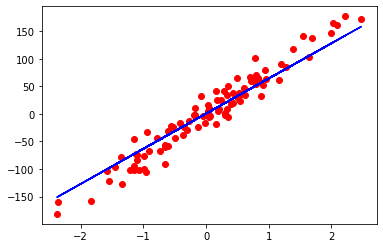

In [93]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

# 0) Prepare data
X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)

# cast to float Tensor
X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))
y = y.view(y.shape[0], 1)

n_samples, n_features = X.shape

# 1) Model
# Linear model f = wx + b
input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size) 

# 2) Loss and optimizer
learning_rate = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

# 3) Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    
    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

# Plot
predicted = model(X).detach().numpy()

plt.plot(X_numpy, y_numpy, 'ro')
plt.plot(X_numpy, predicted, 'b')
plt.show()


### Logistic regression

In [103]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 0) Prepare data
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    def __init__(self, n_input_features):
        super(Model, self).__init__()
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

model = Model(n_features)

# 2) Loss and optimizer
num_epochs = 1000
learning_rate = 0.01
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # Backward pass and update
    loss.backward()
    optimizer.step()

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 100 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


with torch.no_grad():
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
    print(f'accuracy: {acc.item():.4f}')


epoch: 100, loss = 0.2266
epoch: 200, loss = 0.1663
epoch: 300, loss = 0.1390
epoch: 400, loss = 0.1227
epoch: 500, loss = 0.1117
epoch: 600, loss = 0.1036
epoch: 700, loss = 0.0974
epoch: 800, loss = 0.0925
epoch: 900, loss = 0.0884
epoch: 1000, loss = 0.0850
accuracy: 0.9561


## Dataloader

DataLoader can do the batch computation for us

#### To implement custom dataset

* need to inherit dataset
* implement \_\_init\_\_, \_\_getitem\_\_ and \_\_len\_\_

In [13]:
import pandas as pd 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

#df1 = pd.read_csv("wine.data")
#df1.to_csv("wine.csv")

In [15]:
class WineDataset(Dataset):
    def __init__(self):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt('wine.csv', delimiter=',', dtype=np.float32, skiprows=1)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy[:, 1:]) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(xy[:, [0]]) # size [n_samples, 1]
    
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.n_samples
    
dataset = WineDataset()

In [16]:
# get first sample and unpack
first_data = dataset[0]
features, labels = first_data
print(features, labels)


tensor([1.3200e+01, 1.7800e+00, 2.1400e+00, 1.1200e+01, 1.0000e+02, 2.6500e+00,
        2.7600e+00, 2.6000e-01, 1.2800e+00, 4.3800e+00, 1.0500e+00, 3.4000e+00,
        1.0500e+03]) tensor([1.])


In [18]:
# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
train_loader = DataLoader(dataset=dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)


In [19]:
# convert to an iterator and look at one random sample
dataiter = iter(train_loader)
data = dataiter.next()
features, labels = data
print(features, labels)

tensor([[1.3860e+01, 1.5100e+00, 2.6700e+00, 2.5000e+01, 8.6000e+01, 2.9500e+00,
         2.8600e+00, 2.1000e-01, 1.8700e+00, 3.3800e+00, 1.3600e+00, 3.1600e+00,
         4.1000e+02],
        [1.3030e+01, 9.0000e-01, 1.7100e+00, 1.6000e+01, 8.6000e+01, 1.9500e+00,
         2.0300e+00, 2.4000e-01, 1.4600e+00, 4.6000e+00, 1.1900e+00, 2.4800e+00,
         3.9200e+02],
        [1.4830e+01, 1.6400e+00, 2.1700e+00, 1.4000e+01, 9.7000e+01, 2.8000e+00,
         2.9800e+00, 2.9000e-01, 1.9800e+00, 5.2000e+00, 1.0800e+00, 2.8500e+00,
         1.0450e+03],
        [1.2080e+01, 1.1300e+00, 2.5100e+00, 2.4000e+01, 7.8000e+01, 2.0000e+00,
         1.5800e+00, 4.0000e-01, 1.4000e+00, 2.2000e+00, 1.3100e+00, 2.7200e+00,
         6.3000e+02]]) tensor([[2.],
        [2.],
        [1.],
        [2.]])


In [20]:
# Dummy Training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)
for epoch in range(num_epochs):
    #The enumerate() function assigns an index to each item in an iterable object 
    #that can be used to reference the item later
    # trainloader is a tuple returns inputs, labels, and i 
    for i, (inputs, labels) in enumerate(train_loader):
        
        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {inputs.shape} | Labels {labels.shape}')


177 45
Epoch: 1/2, Step 5/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 10/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 15/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 20/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 25/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 30/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 35/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 40/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 45/45| Inputs torch.Size([1, 13]) | Labels torch.Size([1, 1])
Epoch: 2/2, Step 5/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 10/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 15/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 20/45| Inputs torch.Size([4, 1

In [21]:
# some famous datasets are available in torchvision.datasets
# e.g. MNIST, Fashion-MNIST, CIFAR10, COCO

In [ ]:
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),  
                                           download=True)

train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=3, 
                                           shuffle=True)

# look at one random sample
dataiter = iter(train_loader)
data = dataiter.next()
inputs, targets = data
print(inputs.shape, targets.shape)


### Transformers

Transforms can be applied to PIL images, tensors, ndarrays, or custom data
during creation of the DataSet

complete list of built-in transforms: 
https://pytorch.org/docs/stable/torchvision/transforms.html

On Images

CenterCrop, Grayscale, Pad, RandomAffine
RandomCrop, RandomHorizontalFlip, RandomRotation
Resize, Scale

On Tensors
LinearTransformation, Normalize, RandomErasing

Conversion
ToPILImage: from tensor or ndrarray
ToTensor : from numpy.ndarray or PILImage

Generic
Use Lambda 

Custom
Write own class

Compose multiple Transforms:
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

In [25]:

import torch
import torchvision
from torch.utils.data import Dataset
import numpy as np


class WineDataset(Dataset):

    def __init__(self, transform=None):
        xy = np.loadtxt('wine.csv', delimiter=',', dtype=np.float32, skiprows=1)
        self.n_samples = xy.shape[0]

        # note that we do not convert to tensor here
        self.x_data = xy[:, 1:]
        self.y_data = xy[:, [0]]

        self.transform = transform

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return self.n_samples

# Custom Transforms
# implement __call__(self, sample)
class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

class MulTransform:
    # multiply inputs with a given factor
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, sample):
        inputs, targets = sample
        inputs *= self.factor
        return inputs, targets

print('Without Transform')
dataset = WineDataset()
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)

print('\nWith Tensor Transform')
dataset = WineDataset(transform=ToTensor())
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)

print('\nWith Tensor and Multiplication Transform')
composed = torchvision.transforms.Compose([ToTensor(), MulTransform(4)])
dataset = WineDataset(transform=composed)
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))
print(features, labels)


Without Transform

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[1.32e+01 1.78e+00 2.14e+00 1.12e+01 1.00e+02 2.65e+00 2.76e+00 2.60e-01
 1.28e+00 4.38e+00 1.05e+00 3.40e+00 1.05e+03] [1.]

With Tensor Transform
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([1.3200e+01, 1.7800e+00, 2.1400e+00, 1.1200e+01, 1.0000e+02, 2.6500e+00,
        2.7600e+00, 2.6000e-01, 1.2800e+00, 4.3800e+00, 1.0500e+00, 3.4000e+00,
        1.0500e+03]) tensor([1.])

With Tensor and Multiplication Transform
<class 'torch.Tensor'> <class 'torch.Tensor'>
tensor([5.2800e+01, 7.1200e+00, 8.5600e+00, 4.4800e+01, 4.0000e+02, 1.0600e+01,
        1.1040e+01, 1.0400e+00, 5.1200e+00, 1.7520e+01, 4.2000e+00, 1.3600e+01,
        4.2000e+03]) tensor([1.])
